In [26]:
import sys
sys.path.append('/opt/conda/pkgs')
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4506eccf78279d93d0e8a34c035e91c5_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/6bda807e3967eae797c7b1b9eeaee8db_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c2a47d89d1d34e789fdf782557bb7194_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c6c5514ada15b890fb27d1e36371554c_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/d964a294c2d0fef56a434c021026281e_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/e1c932db5cd4271709e54d8028824bc9_/lib/python3.12/site-packages")
import gzip, json
from Bio import SeqIO
import scipy.sparse as sp
from collections import Counter
import numpy as np
import pandas as pd
fasta_gz_file = '/home/miaocj/docker_dir/kNN-overlap-finder/data/regional_reads/Ecoli/all/ONT/reads.fasta.gz'
paf_gz_file = '/home/miaocj/docker_dir/kNN-overlap-finder/data/regional_reads/Ecoli/all/ONT/alignment.paf.gz'
with gzip.open(paf_gz_file, "rt") as file:
    max_values = {}  
    for row in file:  
        columns = row.strip().split('\t') 
        query_id = columns[0]  
        match_bases = int(columns[9]) 
        max_values[query_id] = columns 
        if query_id in max_values:  
            if match_bases > int(max_values[query_id][9]):  
                max_values[match_bases] = columns
        else:  
            continue

In [27]:
import sys
import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy as sp
from typing import Mapping  
import mmh3
from itertools import chain  
import sklearn.neighbors
from scipy.sparse._csr import csr_matrix


In [28]:
from dataclasses import dataclass, field
import mmh3
from functools import lru_cache
import collections
from typing import Sequence, Type, Mapping, Iterable, Literal
from warnings import warn
from math import ceil
from scipy import sparse
from scipy.sparse._csr import csr_matrix
import numpy as np
from numpy import matlib, ndarray
from numpy.typing import NDArray
import sklearn.neighbors
import pynndescent
import hnswlib
import faiss
from numba import njit, prange
from itertools import chain 
from collections import Counter
import secrets
import random
import pynear

In [3]:
sys.path.append("scripts")
sys.path.append("../../scripts")
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges


/home/miaocj/docker_dir/kNN-overlap-finder/scripts/../lib


In [4]:
import numpy as np  
import collections  
from typing import Mapping  
from sklearn.neighbors import NearestNeighbors  
from scipy.spatial.distance import hamming  
import mmh3  
max_n_neighbors = 20
MAX_SAMPLE_SIZE = int(1e9)
k_values = np.arange(2, max_n_neighbors + 1)
def hamming_distance(x, y):  
    return np.count_nonzero(x != y)


In [5]:
npz_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/IGK/ONT_R9/kmer_k16/feature_matrix.npz"
tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/IGK/ONT_R9/kmer_k16/metadata.tsv.gz"
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/IGK/ONT_R9/kmer_k16/read_features.json.gz"

meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}
feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

read_ids = np.array(list(read_features))

In [6]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

(9278, 299092, 18058, 8)

In [8]:
class SimHash():
    @staticmethod
    def _get_hash_table(
        feature_count: int, repeats: int, seed: int
    ) -> NDArray[np.int8]:
        rng = np.random.default_rng(seed)
        hash_table = rng.integers(
            0, 2, size=(feature_count, repeats * 8), dtype=np.int8
        )
        hash_table = hash_table * 2 - 1
        return hash_table
    
    @staticmethod
    def get_simhash(
        data: NDArray | csr_matrix, hash_table: NDArray
    ) -> NDArray[np.uint8]:
        simhash = data @ hash_table
        binary_simhash = np.where(simhash > 0, 1, 0).astype(np.uint8)
        packed_simhash = np.packbits(binary_simhash, axis=-1)
        return packed_simhash

    def get_neighbors(
        self,
        data: csr_matrix | np.ndarray,
        n_neighbors: int,
        repeats=400,
        seed=20141025,
    ) -> np.ndarray:
        assert data.shape is not None
        kmer_num = data.shape[1]
        hash_table = self._get_hash_table(kmer_num, repeats=repeats, seed=seed)
        simhash = self.get_simhash(data, hash_table)
        vptree = pynear.VPTreeBinaryIndex()
        vptree.set(simhash)
        vptree_indices, vptree_distances = vptree.searchKNN(simhash, n_neighbors + 1)
        nbr_indices = np.array(vptree_indices)[:, :-1][:, ::-1]
        return nbr_indices
    

class BlockSimHash(SimHash):
    @staticmethod
    def get_simhash(
        data: NDArray | csr_matrix, hash_table: NDArray, *, block_size=2**30
    ) -> NDArray[np.uint8]:
        sample_count, _ = data.shape
        _, hash_size = hash_table.shape
        if hash_size % 8 != 0:
            raise ValueError()
        result = np.empty(shape=(sample_count, hash_size // 8), dtype=np.uint8)

        # 将稠密矩阵 hash_table 分块，逐块进行乘法计算，减少内存峰值
        for start_col in range(0, hash_size, 8 * block_size):

            end_col = min(start_col + 8 * block_size, hash_size)
            block_hash_table = hash_table[:, start_col:end_col]

            # 进行块矩阵乘法
            block_result = data.dot(block_hash_table)
            binary_block_result = np.where(block_result > 0, 1, 0).astype(np.uint8)
            packed_block_result = np.packbits(binary_block_result, axis=-1)

            # 将结果写入预先分配的结果矩阵
            result[:, start_col // 8 : end_col // 8] = packed_block_result

        return result
    

class NewSimHash(SimHash):
    @staticmethod
    def get_simhash(data: NDArray | csr_matrix, hash_table: NDArray):
        simhash = (data @ hash_table).astype(np.uint8)
        return simhash

In [10]:
feature_matrix.shape

(9280, 1044194)

In [40]:
npz_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/IGK/ONT_R9/kmer_k16/feature_matrix.npz"
feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

In [49]:
nnz = feature_matrix.getnnz(axis=1)

(array([228., 186., 182., 212., 272., 210., 302., 300., 314., 334., 318.,
        318., 302., 290., 318., 236., 264., 260., 230., 230., 238., 236.,
        202., 196., 218., 192., 198., 164., 132., 130., 122., 126., 114.,
        116., 124., 112.,  94.,  90.,  90.,  98.,  78.,  94.,  64.,  50.,
         46.,  42.,  54.,  42.,  46.,  36.,  32.,  28.,  26.,  32.,  16.,
         26.,  34.,  28.,  12.,  16.,  20.,  12.,  16.,  18.,  12.,  14.,
          8.,  10.,   6.,   4.,   8.,   4.,   4.,   6.,   2.,   8.,   0.,
          4.,   0.,   4.,   2.,   2.,   2.,   4.,   2.,   0.,   0.,   4.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([  11.  ,   82.63,  154.26,  225.89,  297.52,  369.15,  440.78,
         512.41,  584.04,  655.67,  727.3 ,  798.93,  870.56,  942.19,
        1013.82, 1085.45, 1157.08, 1228.71, 1300.34, 1371.97, 1443.6 ,
        1515.23, 1586.86, 1658.49, 1730.12, 1801.75, 1873.38, 1945.01,
        2016.64, 2088.27, 2159.9 ,

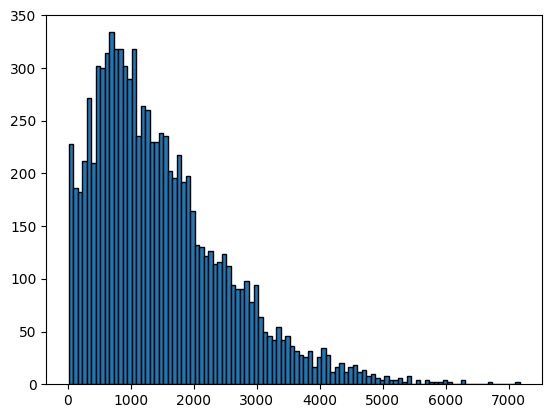

In [ ]:
plt.hist(nnz, bins=100, edgecolor='black')

In [ ]:
mysim = NewSimHash()
hash_table = mysim._get_hash_table(1044194,400,5420)
newsim = feature_matrix@hash_table
flattened_matrix = newsim.flatten()

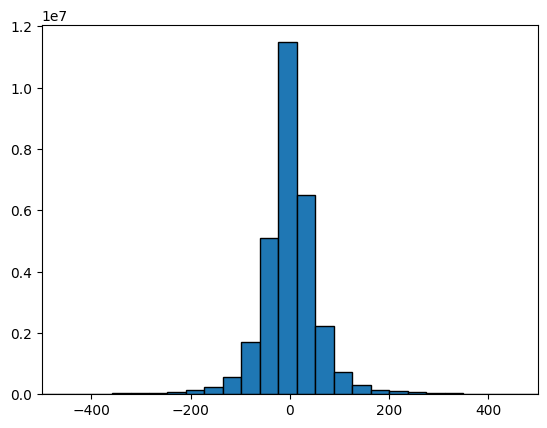

In [43]:
plt.hist(flattened_matrix, bins=100, edgecolor='black')
plt.xlim(-500,500)
plt.show()

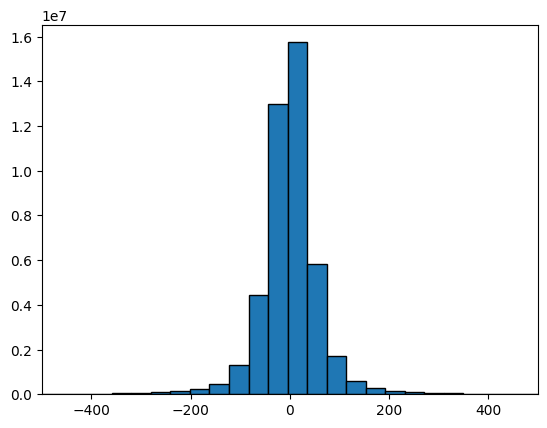

In [44]:
mysim = NewSimHash()
hash_table = mysim._get_hash_table(1044194,600,5420)
newsim = feature_matrix@hash_table
flattened_matrix = newsim.flatten()
plt.hist(flattened_matrix, bins=100, edgecolor='black')
plt.xlim(-500,500)
plt.show()

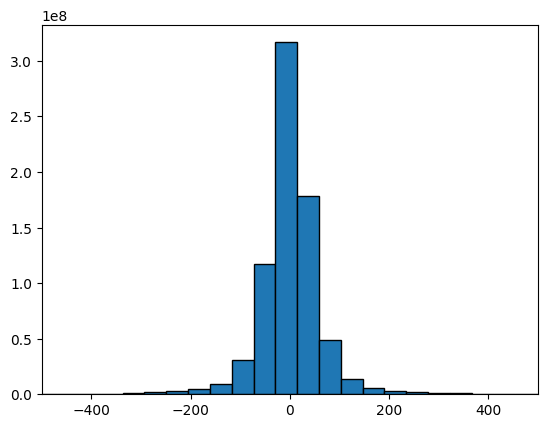

In [48]:
mysim = NewSimHash()

hash_table = mysim._get_hash_table(1044194,10000,5420)
newsim = feature_matrix@hash_table
flattened_matrix = newsim.flatten()
plt.hist(flattened_matrix, bins=100, edgecolor='black')
plt.xlim(-500,500)
plt.show()

In [47]:
newsim.shape

(9280, 8000)

In [ ]:
npz_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/human/HLA/ONT_R9/kmer_k16/feature_matrix.npz"
feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]
mysim = NewSimHash()
hash_table = mysim._get_hash_table(feature_matrix.shape[1],400,5420)
newsim = feature_matrix@hash_table
flattened_matrix = newsim.flatten()


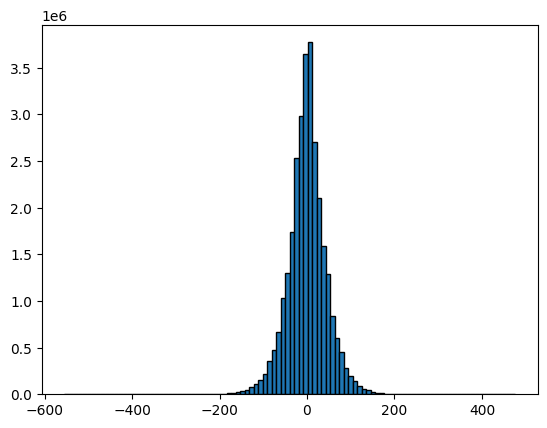

In [39]:
plt.hist(flattened_matrix, bins=100, edgecolor='black')
plt.show()

In [20]:
feature_matrix.shape

(9280, 2040722)

In [21]:
hash_table = mysim._get_hash_table(2040722,400,5420)
newsim = feature_matrix@hash_table

In [22]:
np.min(newsim)

-555

In [23]:
np.max(newsim)

476

In [65]:
##64bit
kmer_num = feature_matrix.shape[1]
def _hash64(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash128(str(kmer_index), seed=seed)
    binary_string = "{0:0128b}".format(hash_value)[:64]
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int64) 
    hash_array = np.where(hash_array == 0, -1, 1)
    return hash_array
def _hash32(kmer_index: int, seed: int) -> np.ndarray:  
    hash_value = mmh3.hash(str(kmer_index), seed=seed)  
    binary_string = "{0:032b}".format(hash_value & 0xFFFFFFFF)  
    hash_array = np.array([int(x) for x in binary_string], dtype=np.int64) 
    hash_array = np.where(hash_array == 0, -1, 1)
    return hash_array
def get_table(
    kmer_num: int,
    bit: int,
    *,
    seed: int,
    repeat=100) -> Mapping[int,list]:  
    
    rng = np.random.default_rng(seed)  
    hash_seeds = rng.integers(low=0, high=2**32 - 1, size=repeat, dtype=np.uint64)  

    hash_table = np.empty((kmer_num,repeat,bit),dtype=np.int8)
    if bit == 32:
        for flag,seed in enumerate(hash_seeds):
            for kmer_index in range(kmer_num):
                hash_table[kmer_index,flag,:]=_hash32(kmer_index, seed=seed)
                new_hash_table=np.reshape(hash_table,(kmer_num,repeat*bit))
    else:
        for flag,seed in enumerate(hash_seeds):
            for kmer_index in range(kmer_num):
                hash_table[kmer_index,flag,:]=_hash64(kmer_index, seed=seed)
                new_hash_table=np.reshape(hash_table,(kmer_num,repeat*bit))
    return new_hash_table

print("done\nbuilding hash table")
hash_table = get_table(kmer_num,64,seed=4829,repeat=100) 
print("done\nget ref simhash")
reads_simhash_array = get_simhash(read_features,hash_table)
print("ref done\nget que simhash")

done
building hash table
done
get ref simhash
ref done
get que simhash


In [66]:
all_read_simhash=[]
for read_kmer in read_features.values():
    one_read_hash = np.sum(hash_table[read_kmer,:],axis=0)
    simhash = np.where(one_read_hash > 0, 1, 0)
    all_read_simhash.append(simhash)
reads_simhash_array = np.array(all_read_simhash)

In [67]:
nbrs = NearestNeighbors(n_neighbors=21, algorithm='auto', metric=hamming_distance)
nbrs.fit(reads_simhash_array)  
indices = nbrs.kneighbors(reads_simhash_array,return_distance=False)
nbr_indices = indices[:, 1:]

df_rows = []
for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    stats = { "n_neighbors": k}
    stats = {"description":'SimHash_TF-64bit', "n_neighbors": k, "repeat_time": 100,
                **graph_stats}
    df_rows.append(stats)
df_64_100 = pd.DataFrame(df_rows)
#df_tfidf.to_csv('/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/human/HLA/ONT_R9/kmer_k16/SimHash_None_None_overlap_stat.tsv',sep='\t')

In [59]:
df_32 = df_tfidf
df_32

,description,n_neighbors,repeat_time,precision,nr_precision,recall,nr_recall,singleton_count,singleton_fraction,N50,N50_percentage
0,SimHash_TF-32bit,2,20,0.651445,0.190600,0.032625,0.158102,3264,0.351724,36,0.39%
1,SimHash_TF-32bit,3,20,0.637118,0.168185,0.047002,0.205504,2344,0.252586,129,1.39%
2,SimHash_TF-32bit,4,20,0.627593,0.153297,0.060898,0.246373,1756,0.189224,199,2.14%
3,SimHash_TF-32bit,5,20,0.618968,0.141842,0.074278,0.281925,1373,0.147953,231,2.49%
4,SimHash_TF-32bit,6,20,0.611235,0.131726,0.087314,0.311662,1137,0.122522,233,2.51%
5,SimHash_TF-32bit,7,20,0.603782,0.123964,0.099825,0.339462,974,0.104957,233,2.51%
6,SimHash_TF-32bit,8,20,0.597160,0.117634,0.112190,0.366043,854,0.092026,293,3.16%
7,SimHash_TF-32bit,9,20,0.591349,0.111601,0.124333,0.388637,763,0.082220,300,3.23%
8,SimHash_TF-32bit,10,20,0.585335,0.106146,0.136122,0.408849,676,0.072845,300,3.23%
9,SimHash_TF-32bit,11,20,0.580774,0.102252,0.147821,0.431055,611,0.065841,336,3.62%


In [64]:
df_64.to_csv('/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/human/IGK/ONT_R9/kmer_k16/SimHash_64bit_re20_overlap_stat.tsv',sep='\t')

In [68]:
df_64_100.to_csv('/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/human/IGK/ONT_R9/kmer_k16/SimHash_64bit_re100_overlap_stat.tsv',sep='\t')

In [47]:
df_tfidf

,description,n_neighbors,repeat_time,precision,nr_precision,recall,nr_recall,singleton_count,singleton_fraction,N50,N50_percentage
0,SimHash_TF-IDF,2,20,0.980431,0.313947,0.060799,0.250079,285,0.022049,235,1.82%
1,SimHash_TF-IDF,3,20,0.976904,0.279217,0.088720,0.325724,212,0.016401,2680,20.73%
2,SimHash_TF-IDF,4,20,0.973521,0.253844,0.115842,0.387997,184,0.014235,3344,25.87%
3,SimHash_TF-IDF,5,20,0.970673,0.233653,0.142515,0.440655,163,0.012610,6414,49.62%
4,SimHash_TF-IDF,6,20,0.968060,0.217870,0.168686,0.487656,153,0.011837,6421,49.68%
5,SimHash_TF-IDF,7,20,0.965841,0.205076,0.194552,0.530622,141,0.010908,6423,49.69%
6,SimHash_TF-IDF,8,20,0.963133,0.193493,0.219910,0.567495,132,0.010212,6428,49.73%
7,SimHash_TF-IDF,9,20,0.960397,0.184195,0.244615,0.602627,130,0.010057,6431,49.75%
8,SimHash_TF-IDF,10,20,0.957749,0.175097,0.269150,0.632062,126,0.009748,6432,49.76%
9,SimHash_TF-IDF,11,20,0.955166,0.167919,0.293248,0.662209,123,0.009516,6434,49.78%
